# Causal analysis

## Toy medicine data

The data is retrieved from the [causality challenge](http://www.causality.inf.ethz.ch/challenge.php). The LUCAS (LUng CAncer Simple set) toy dataset was generated from the causal graphical model shown below. The conditional probabilities were completely made up; they have no biological meaning !

<img width="50%" src="img/lucas_dag.png">


In [1]:
#let's import the data
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

lucas = pd.read_csv("data/lucas0_train.csv")
lucas.head()

,smoking,yellow_fingers,anxiety,peer_pressure,genetics,attention_disorder,born_an_even_day,car_accident,fatigue,allergy,coughing,lung_cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1


## Causal feature : Smoking

In the causal graph above, smoking is a direct cause of lung cancer. Let's see if we can recover this in the data.
First we compute the contingency table and perform a statistical test called the [G-test](https://en.wikipedia.org/wiki/G-test) to see if lung_cancer is independent of smoking or not. If smoking is indeed a causal factor of lung cancer, there should be a clear statistical association between the two.

In [2]:
from scipy.stats import chi2_contingency
# significance level
alpha = 0.05 

In [3]:
# contingency table
contingency = pd.crosstab(index=lucas["smoking"], columns=lucas["lung_cancer"])
# independence G-test
chi2, p_value, _, _ = chi2_contingency(contingency, lambda_="log-likelihood")
print(f"chi2 = {chi2:.2f} with p_value={p_value:.2e} independent: {p_value > alpha}")
contingency

chi2 = 447.28 with p_value=2.83e-99 independent: False


lung_cancer,0,1
smoking,,
0,328,167
1,229,1276


We can also estimate $P(\text{lung_cancer}|\text{smoking})$ by looking at the observed frequencies.

In [4]:
# estimate P(lung_cancer|smoking)
frequencies = pd.crosstab(
    index=lucas["smoking"], columns=lucas["lung_cancer"],
    normalize="index"
)
frequencies

lung_cancer,0,1
smoking,,
0,0.662626,0.337374
1,0.152159,0.847841


And visualize the estimated conditional probalilty using a barplot. We clearly see that smoking is associated with a higher risk of lung cancer.

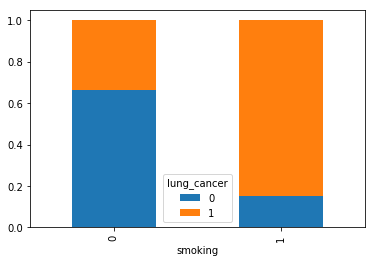

In [5]:
# barplot P(lung_cancer|smoking)
frequencies.plot.bar(stacked=True);

## Irrelevant feature : Born an even day

In the causal graph above, "born an even day" is a completely irrelevant feature, that should not correlate with lung cancer. Let's compute the contingency table and check that "born an even day" is statistically independent of lung cancer.

In [6]:
# contingency table
contingency = pd.crosstab(index=lucas["born_an_even_day"], columns=lucas["lung_cancer"])
# independence G-test
chi2, p_value, _, _ = chi2_contingency(contingency, lambda_="log-likelihood")
print(f"chi2 = {chi2:.2f} with p_value={p_value:.2e} independent: {p_value > alpha}")
contingency

chi2 = 0.23 with p_value=6.29e-01 independent: True


lung_cancer,0,1
born_an_even_day,,
0,279,742
1,278,701


We can also check it visually, the observed frequency of lung cancer clearly does not depend on whether the subject was born an even day or not.

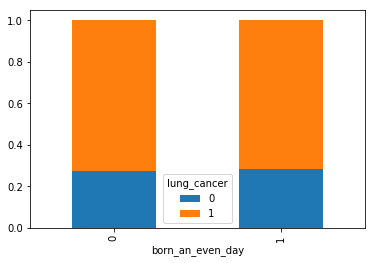

In [7]:
# barplot P(lung_cancer|born_an_even_day)
pd.crosstab(
    index=lucas["born_an_even_day"], columns=lucas["lung_cancer"],
    normalize="index"
).plot.bar(stacked=True);

## Selection bias:  allergy

Say a study was performed on patients that consulted for a cough. The data shows a clear association between allergy 
and lung cancer, and that allergy seems to lower the risk for lung cancer !

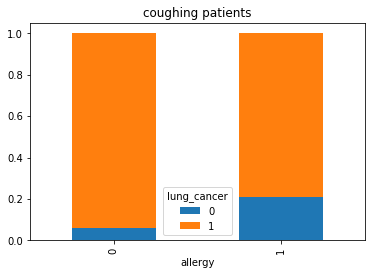

In [8]:
# barplot P(lung_cancer|allergy) for coughing patients
patients = lucas.query("coughing==1")
pd.crosstab(
    index=patients["allergy"], columns=patients["lung_cancer"],
    normalize="index"
).plot.bar(stacked=True, title="coughing patients");

**Exercice** Based on your knowledge of the causal graph, explain what is wrong in the reasoning above. Plot the relevant conditional probabilty to show that allergy has in fact no impact on lung cancer.

In [9]:
# %load exo1.py

## Confounder : yellow fingers

In the data there is a clear association between yellow fingers and lung cancer. Does this mean that staining fingers in yellow increases the risk of getting lung cancer ?

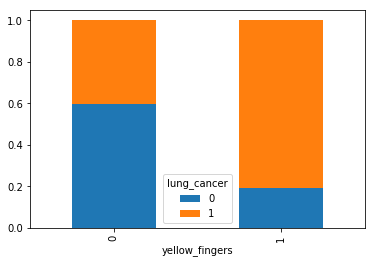

In [10]:
# barplot P(lung_cancer|yellow_fingers)
pd.crosstab(
    index=lucas["yellow_fingers"], columns=lucas["lung_cancer"],
    normalize="index"
).plot.bar(stacked=True);

**Exercise** Based on your knowledge of the causal graph, explain what is wrong in the above reasoning. Plot the relevant conditional probabilty to show that yellow fingers has in fact no impact on lung cancer.

In [11]:
# %load exo2.py

## Interpreting regression coefficients

The Berkson's paradox (statistical association created when conditioning on a common effect)
and the Simpson's paradox (confouding created by a hidden common cause) imply that you should be **particularly careful when interpreting regression coefficients**. In particular it is always very tempting to interpret causally the regression coefficients. For instance, when a coefficient is positive, negative or exactly zero, we often naturally interpret this as saying that the feature has a positive, negative or no impact on the target. However this interpretation is often problematic as we will illustrate below.  

Let's say we train a sparse logistic regression model to predict lung cancer from all other features and plot the learned regression coefficients.

Test accuracy: 0.8625


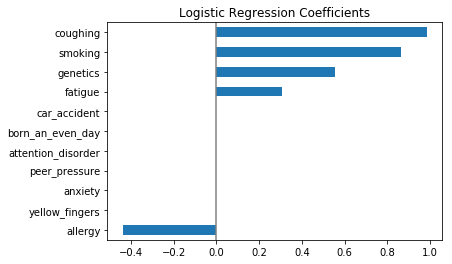

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

features = [column for column in lucas.columns if column !="lung_cancer"]
X, y = lucas[features].astype(float), lucas["lung_cancer"].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression(C=0.03, penalty="l1", solver="saga")
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print(f"Test accuracy: {accuracy}")

coefficients = pd.Series(clf.coef_[0], index=features).sort_values()
coefficients.plot.barh(title="Logistic Regression Coefficients").axvline(0, color='grey');

We see that smoking and genetics increase the risk of lung cancer and that is also true causally. However you see that the highest regression coeffcient is the coughing feature, which is an effect and not a cause of lung cancer. This is perfectly normal : effects can be very informative on the target and important for predictive performance. For instance if the soil is wet you can predict that it has rained.

We also see that allergy has a quite important negative coefficient, although allergy is not causally related to lung cancer. But remember that we predicting lung cancer as a function of all other covariates, that is we are estimating the conditional probality $P(\text{lung_cancer}|\text{all other features})$. In particular we are conditioning on coughing, so allergy becomes statistically associated with lung cancer and very informative for the prediction. 

Remember that a machine learning algorithm is fundamentally exploiting **statistical associations** between the target and the features to make a prediction. It does not matter to the algorithm that the associations are due to confounding, selection bias, or that the feature is actually a consequence (and not a cause) of the target.

It is very instructive to see what happens to the regression coefficients when we change the set of covariates (features used in the regression). For example let's remove smoking from the set of features.

Test accuracy: 0.8175


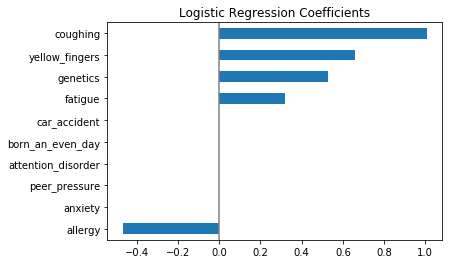

In [13]:
features = [
    column for column in lucas.columns 
    if column not in ["lung_cancer","smoking"]
]
X, y = lucas[features].astype(float), lucas["lung_cancer"].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression(C=0.03, penalty="l1", solver="saga")
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print(f"Test accuracy: {accuracy}")

coefficients = pd.Series(clf.coef_[0], index=features).sort_values()
coefficients.plot.barh(title="Logistic Regression Coefficients").axvline(0, color='grey');

You see that the feature yellow fingers that had a zero coefficient in the full regression has jumped at the second place ! With the underlying causal model it is very easy to explain : in the absence of the smoking feature, yellow fingers is now statistically associated to lung cancer due to the confounding effect of smoking (now a latent variable). Yellow fingers, being a consequence of smoking, is used as a statistical proxy of smoking that is indeed very informative on the target. 

By the way, this example illustrates that we cannot really speak of "the" regression coefficient of feature X, and even less interpret it as "the effect of X on Y". The regression coefficient for a feature X does not only depend on the feature X, but on **the whole set of covariates**. For the yellow fingers example, when smoking was in the set of covariates the coefficient was zero and when smoking was absent the coefficient was positive and quite high. In some situations even the sign of the regression coefficient can flip when we change the set of covariates.

**Exercise** Remove coughing, fatigue, and car_accident from the set of covariates. What happens to the regression coefficients ? Can you explain why ?

In [14]:
# %load exo3.py

## Inferring the causal structure on real sociological data

To understand what factors influence the intention of high school students to attend college or not, Sewell and Shah (1968) collected the following data on a cohort of 10318 high-school students:

- IQ : intellectual quotient from 0=low to 4=high
- SES : socio-economical status from 0=low to 4=high
- PE : parental encouragement 0=low or 1=high
- SEX : male or female
- college_plans : whether the student intends to attend college or not

Heckerman et al (1997) used a Bayesian approach to infer the underlying causal graphical model.
They found that the posterior probabilty over causal structures was extremely peaked, the most probable causal model has a posterior probality of almost one.

**References**
- W. Sewell and V. Shah (1968). Social Class, Parental Encouragement, and Educational Aspirations. American Journal of Sociology, Volume 73, Issue 5, 559-572.
- D. Heckerman, C. Meek and G. Cooper (1997). A Bayesian approach to causal discovery. Technical Report MSR-TR-97-05, Microsoft Research.

In [15]:
import pandas as pd
students = pd.read_csv("data/student_college_plans.csv")
print("There are", students.shape[0], "students")
students.head()

There are 10318 students


,IQ,PE,SES,SEX,college_plans
0,3,1,2,female,yes
1,1,0,1,male,no
2,3,1,3,male,yes
3,2,0,1,male,no
4,3,0,1,female,no


For instance we might expect that IQ should have a positive causal effect on attending college. Is the data compatible with this causal claim ? If so, there should be a statistical dependence of college plans upond IQ.

Indeed, there is a clear relationship between IQ and college plans. Note that this not by itself a proof, as there could be confounding factors.


chi2 = 1560.24 with p_value=0.00e+00 independent: False


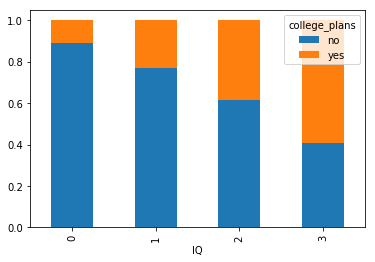

In [16]:
# contingency table
contingency = pd.crosstab(index=students["IQ"], columns=students["college_plans"])
# independence G-test
chi2, p_value, _, _ = chi2_contingency(contingency, lambda_="log-likelihood")
print(f"chi2 = {chi2:.2f} with p_value={p_value:.2e} independent: {p_value > alpha}")
# barplot P(college_plans|IQ)
pd.crosstab(
    index=students["IQ"], columns=students["college_plans"], 
    normalize="index"
).plot.bar(stacked=True);

**Exercise** which of the following causal claims is compatible with the data ?

1. SEX $\rightarrow$ college_plans $\leftarrow$ PE
2. SEX $\rightarrow$ PE $\rightarrow$ college_plans

In [17]:
# %load exo4.py

## Complete causal model

By exploring all conditional independence relationships satisfied by the data it is possible to recover the underlying causal graphical structure, up to what is called Markov equivalence. Two directed acyclic graphs (causal models) are Markov equivalent if they share the same undirected skeleton and the same set of v-structures (stuctures of the type $X\rightarrow Y \leftarrow Z$). 

This learning task, inferring the causal structure from data, is called **causal discovery**. There are many algorithms to perform causal discovery. Using Bayesian inference, Heckerman et al (1997) found that the following DAG structure had overwhelming posterior probabilty for the college plans data:

<img width="30%" src="img/college_plans_dag.png">

The **PC algorithm** (named after Peter Spirtes and Clark Glymour) is a classic algorithm to perform causal discovery. Using the PC algorithm from the [TETRAD software](http://www.phil.cmu.edu/tetrad/index.html), you will obtain the following causal structure for the LUCAS dataset:

<img width="30%" src="img/pc_lucas_dag.png">

Except for the fatigue $\rightarrow$ lung cancer arrow, the estimated causal structure is correct!
For the college plans dataset, the causal structure estimated by the PC algorithm is very close to the DAG inferred
by Heckerman et al:


<img width="30%" src="img/pc_college_plans_dag.png">


>This is an important take home message: sure the mantra **correlation does not imply causation** is correct, but it is incomplete! The good news is **from a set of correlations, you can infer causation**.

## Further resources

[Advanced Data Analysis from an Elementary Point of View](https://www.stat.cmu.edu/~cshalizi/ADAfaEPoV/) by Cosma Shalizi. Part III is a self-contained and very clear introduction to causal inference.

The [TETRAD software](http://www.phil.cmu.edu/tetrad/index.html) contains many state-of-the-art causal inference algorithms (both for causal discovery and intervention prediction).

The python package [dowhy](https://causalinference.gitlab.io/dowhy/) is also dedicated to causal inference. 